In [1]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [104]:
import numpy as np
import os 
from matplotlib import pyplot as plt
from tqdm import tqdm
from helper_funcs import *

import pandas as pd
from umap import UMAP

In [91]:
ofdir = '../Assets/abide_1_cmats'
cmat_files = os.listdir(ofdir)
cmat_files.sort()
cmats = np.array([np.load(os.path.join(ofdir,cmat_file)) for cmat_file in tqdm(cmat_files)])

100%|██████████| 1102/1102 [00:00<00:00, 4479.82it/s]


In [92]:
has_nans = np.array([np.isnan(cmats[i,:,:]).sum()>0 for i in range(cmats.shape[0])])
cmats = cmats[~has_nans,:,:]
has_nans.sum()

14

In [93]:
cmats.shape

(1088, 51, 51)

In [94]:
csubs = [cmat_file.replace('.npy','') for cmat_file in cmat_files]
csubs = np.array(csubs)
csubs = csubs[~has_nans]

df = pd.read_csv('../Data/ABIDE_df2.csv')
is_indf = np.array([val in csubs for val in df['bids_folder'].values])
is_incsubs = np.array([val in csubs for val in df['bids_folder'].values])
is_in = is_indf*is_incsubs
df = df.iloc[is_in]
patients = df['DX_GROUP'].values==1
df.shape

(1048, 75)

In [95]:
c_in_df = [csub in df['bids_folder'].values for csub in csubs]
cmats = cmats[c_in_df,:,:]
cmats.shape

(1048, 51, 51)

In [98]:
cmats_asd = cmats[patients,:,:]
df_asd = df.iloc[patients]

In [41]:
#np.array(cmat_files)[has_nans]

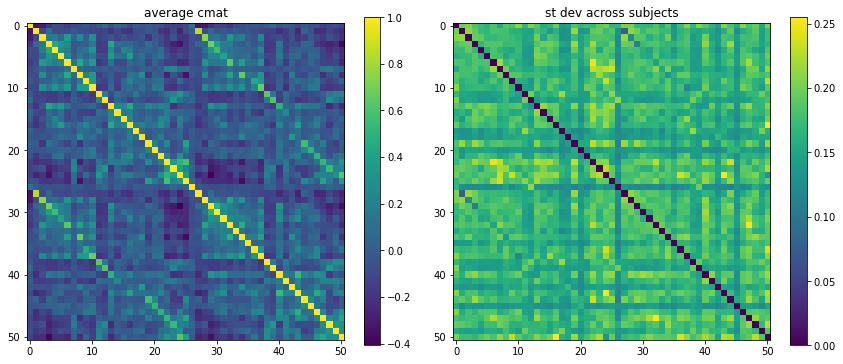

In [262]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(cmats_asd.mean(axis=0));plt.title('average cmat')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(cmats_asd.std(axis=0));plt.title('st dev across subjects')
plt.colorbar()

plt.tight_layout()

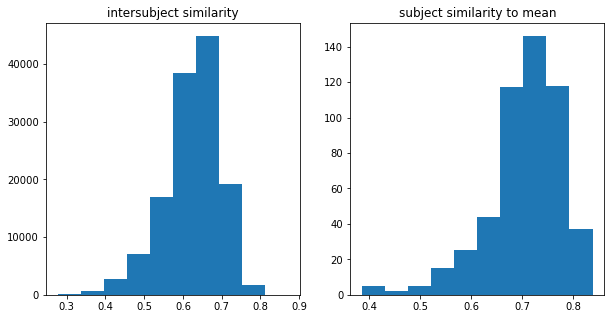

In [100]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(get_triu(np.corrcoef(cmats_asd.reshape(cmats_asd.shape[0],-1))));
plt.title('intersubject similarity');

plt.subplot(1,2,2)
plt.hist([np.corrcoef(get_triu(cmats_asd.mean(axis=0)),get_triu(cmats_asd[i,:,:]))[0,1] for i in range(cmats_asd.shape[0])]);
plt.title('subject similarity to mean');

In [101]:
cmats_asd.shape

(514, 51, 51)

In [135]:
# age = df_asd['AGE_AT_SCAN'].values
# age = (age - age.mean()) / age.std()
# #age = (age-min(age)) / (max(age)-min(age))

In [137]:
# plt.scatter(umap_cmats_asd[:,0],umap_cmats_asd[:,1],c=age)

Text(0.5, 0.98, 'ASD subject similarity')

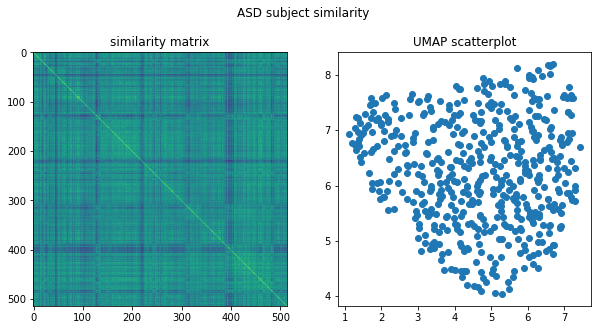

In [264]:
umap_cmats_asd = UMAP(n_components=2).fit_transform(cmats_asd.reshape(cmats_asd.shape[0],-1))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1,box_aspect=1);plt.title('similarity matrix')
plt.imshow(np.corrcoef(cmats_asd.reshape(cmats_asd.shape[0],-1)))
plt.subplot(1,2,2,box_aspect=1)
plt.scatter(umap_cmats_asd[:,0],umap_cmats_asd[:,1]);plt.title('UMAP scatterplot')

plt.suptitle('ASD subject similarity')
##plt.tight_layout()
#plt.subplots_adjust()

In [17]:
patients = df['DX_GROUP'].values==1

In [18]:
def key_rsa(key,df,data_scale='ratio', metric='euclidean'):
    #initial_slice = patients
    vec = df[key].values[initial_slice]
    sub_slice = ~np.isnan(vec)

    rdm_model = make_RDM(vec[sub_slice],data_scale='ratio', metric='euclidean')
    rdm_bg = np.array([make_RDM(data['BG_ABIDE'][i,initial_slice,:][sub_slice,:]) for i in range(10)])
    rdm_sl = np.array([make_RDM(data['SL_ABIDE'][i,initial_slice,:][sub_slice,:]) for i in range(10)])

    rsa_result = np.zeros((2,10))
    rsa_result[0,:] = fit_rsa(rdm_bg,rdm_model)
    rsa_result[1,:] = fit_rsa(rdm_sl,rdm_model)
    return rsa_result

In [255]:
import scipy
corr = scipy.stats.kendalltau
def key_rsa_rois(key,use_mats,use_df):
#     key = 'ADOS_TOTAL'
#     use_df = df_asd
#     use_mats = cmats_asd

    assert len(use_df)==len(use_mats), 'bad stuff'

    e = np.isnan(use_df[key].values)
    n = (~e).sum()

    model_vec = use_df[key].values[~e]
    
    if key in ('DSM_IV_TR','SEX','site'):
        data_scale='ordinal'
    else:
        data_scale='ratio'
    model_rdm = make_RDM(model_vec,data_scale=data_scale, metric='euclidean')

    data_rdm = make_RDM(use_mats[~e,:,:].reshape(n,-1),data_scale='ratio', metric='correlation')

    r = corr(get_triu(model_rdm),get_triu(data_rdm))[0]
    
    rsa_result = {'key':key,'r':r, 'n':n, 'model_rdm':model_rdm,'data_rdm':data_rdm}
    return rsa_result

In [259]:
keys = ['AGE_AT_SCAN','DSM_IV_TR', 'SEX','FIQ', 'ADOS_TOTAL', 'ADOS_COMM', 'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV','SRS_RAW_TOTAL','site']
rsa_results = [key_rsa_rois(key,cmats_asd,df_asd) for key in keys]
rsa_vals = [rsa_result['r'] for rsa_result in rsa_results]

In [260]:
[rsa_result['n'] for rsa_result in rsa_results]

[514, 477, 514, 481, 365, 340, 341, 281, 190, 514]

Text(0.5, 1.0, 'ROI RDM RSA by key')

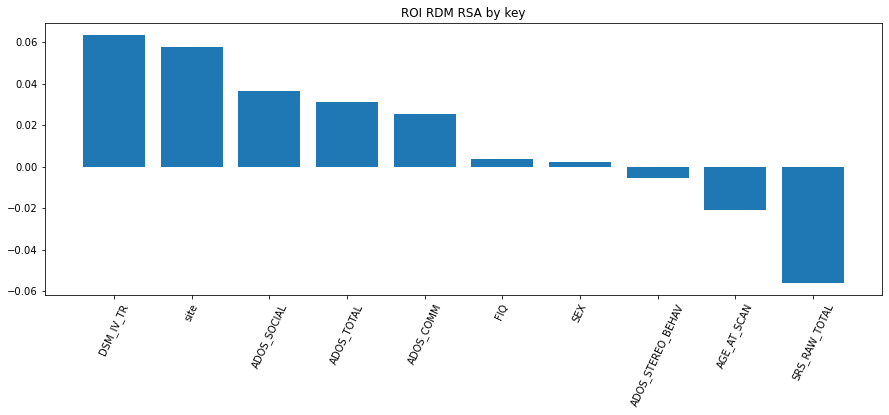

In [266]:
ys = np.array(rsa_vals)
xs = np.arange(len(ys))
lbls = np.array(keys)

ord_ = np.argsort(ys)[-1::-1]
ys = ys[ord_]
lbls = lbls[ord_]

plt.figure(figsize=(15,5));
plt.bar(xs,ys);
plt.xticks(xs,labels=lbls,rotation=65);
plt.title('ROI RDM RSA by key')